In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-on-movie-reviews/sampleSubmission.csv
/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip
/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip


In [3]:
!nvidia-smi

Fri Dec 23 13:35:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |  15781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
#!pip install tensorflow-gpu==2.4.0

In [5]:
import zipfile

z= zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/train.tsv.zip')
z.extractall()

z= zipfile.ZipFile('/kaggle/input/sentiment-analysis-on-movie-reviews/test.tsv.zip')
z.extractall()

In [6]:
df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Preprocessing

<AxesSubplot:>

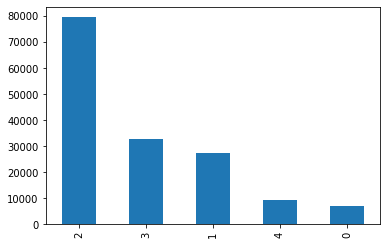

In [7]:
df['Sentiment'].value_counts().plot(kind = 'bar')

In [8]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [9]:
from transformers import BertTokenizer

In [10]:
!pip install bert-for-tf2
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 412.3 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=ec06a5fa9bdb2a178c84574273aa38695cba985a432e2b7c9e544190ff8ad4fb
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=cd5915b613f5c9acab376a820768d7fafb07ff80ba90c8da7ff8122cffd3e66d
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=0505c57c6d055c627267642abc98911b46ce914d9fe1e1988ccff7c558306d23
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22d

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
tokens = tokenizer(df['Phrase'].tolist(), 
                   max_length = seq_len,
                   truncation = True,
                   padding = 'max_length',
                   add_special_tokens = True,
                   return_tensors = 'np'
                  )

In [13]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [14]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [15]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [16]:
import numpy as np

with open('movie_xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie_xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [17]:
arr = df['Sentiment'].values

In [18]:
arr.shape

(156060,)

In [19]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [20]:
arr.max()+1

5

In [21]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [22]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [23]:
labels[np.arange(num_samples), arr] = 1

In [24]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [25]:
with open('movie_labels.npy', 'wb') as f:
    np.save(f, labels)

# Building Dataset

In [26]:
Xids = tokens['input_ids']
Xmask = tokens['attention_mask']

In [27]:
Xids.shape

(156060, 512)

In [28]:
import tensorflow as tf

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

2022-12-23 13:36:56.839818: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 639221760 exceeds 10% of free system memory.
2022-12-23 13:36:58.222129: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 639221760 exceeds 10% of free system memory.
2022-12-23 13:36:59.130774: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 639221760 exceeds 10% of free system memory.


In [30]:
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [31]:
# to get following format we use map_func function
# {input_id, attention_mask}, outputs

def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids,
           'attention_mask': masks}, labels

In [32]:
dataset = dataset.map(map_func)

In [33]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

# Dataset batch, split and shuffle

In [34]:
batch_size = 16

In [35]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

In [36]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [37]:
split = 0.9

In [38]:
size  = int ((Xids.shape[0] / batch_size) * split)

In [39]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [40]:
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [41]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

2022-12-23 13:37:00.564059: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [42]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# Build and Train

In [43]:
from transformers import TFAutoModel

In [44]:
!wget https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-tf_model.h5

--2022-12-23 13:37:14--  https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-tf_model.h5
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.141.64, 52.216.112.165, 52.216.241.102, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.141.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 526681800 (502M) [binary/octet-stream]
Saving to: ‘bert-base-cased-tf_model.h5.2’

bert-base-cased-tf_ 100%[===================>] 502.28M  14.6MB/s    in 37s     

2022-12-23 13:37:53 (13.4 MB/s) - ‘bert-base-cased-tf_model.h5.2’ saved [526681800/526681800]



In [45]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [46]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [47]:
# two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[1]

# classifier head
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation = 'softmax', name='outputs')(x)

In [48]:
model = tf.keras.Model(inputs = [input_ids, mask], outputs=y)

In [49]:
model.layers[2].trainable = False          # use already trained layers

In [50]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         787456      bert[0][1]                   

In [51]:
optimizer = tf.keras.optimizers.Adam(lr=e-5, decay=1e-6) #optimal values for bert. may need tuning
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
!nvidia-smi

Fri Dec 23 13:38:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    32W / 250W |  16235MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [54]:
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        epochs = 3
    )

Epoch 1/3
8778/8778 [==============================] - 3781s 430ms/step - loss: 1.1107 - accuracy: 0.5526 - val_loss: 1.0738 - val_accuracy: 0.5671
Epoch 2/3
8778/8778 [==============================] - 3774s 430ms/step - loss: 1.0510 - accuracy: 0.5710 - val_loss: 1.0834 - val_accuracy: 0.5503
Epoch 3/3
8778/8778 [==============================] - 3771s 430ms/step - loss: 1.0311 - accuracy: 0.5790 - val_loss: 1.0101 - val_accuracy: 0.5753


In [60]:
model.save('sentiment_model')

2022-12-22 20:52:20.927238: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
